## Overfeat (dense evaluation)
- OverFeat은 classificatio, localization 및 detection에 대한 통합 프레임 워크를 제공하는 것을 목표로 개발되었다.
- OverFeat는 1-pass로 연산이 가능한 구조를 취하고 있기 때문에, 약 2000여개의 후보영역에 ConvNet 연산을 해야하는 R-CNN보다 연산량 관점에서 효과적이었으며, 뒤에, R-CNN의 문제점을 해결한 SPPNet 설계자들에게 힌트가 되었을 것같다. 
- SPPNet 역시 1-pass 구조를 취하고 있는데, 이들은 OverFeat이 사용한 dense evaluation 방법보다 진보된 Spatial Pyramid Pooling(SPP) 방식을 사용한다.

## OverFeat
- Overfeat은 fast와 accurate 2개의  model이 있으며, fast model은 AlexNet과 마찬가지로 5 Layer의 convolution layer/pooling layer 및 3개의 fully connected layer로 구성이 된다. 
- Accurate model은 연산 시간은 좀더 걸리더라도 정확도 향상을 위해 convolution/ pooling layer가 1개 더 추가가 되었다.
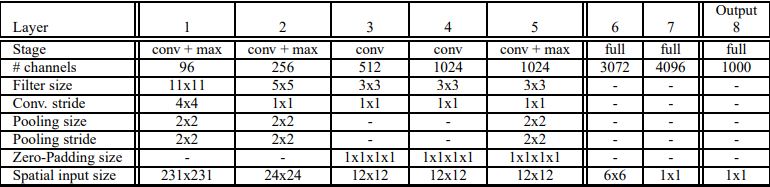
- 위 표(fast model)에서 볼 수 있는 것처럼, 전형적인 구조를 취하고 있으며, VGGNet의 주장처럼 LRN(local Response Nomalization)은 별 효과가 없다고 하여 사용하지 않고 있으며, AlexNet과 같은 overlapped pooling 대신에 non-overlapped pooling 방식을 사용하고 있다.

## 학습방법
- classification은 학습에는 모든 학습영상을 256크기로 scaling하고 231x231크기로 multi-crop을 한다.
- AlexNet과 마찬가지로 코너에서 4개의 중앙에서 1개, 총 5개의 영상을 무작위로 고르고, 이것들과 좌우반전 영상 총 10개의 영상을 학습 영상으로 사용한다.

## 테스트 방법 - (Multi-scale dense evaluation)
- OverFeat은 multi-crop voting 방식 대신에 dense evalution방식을 사용하였다.
- multi-crop voting을 사용하는 경우는 서로 겹치는 부분이 있더라도 ConvNet연산을 전부 새롭게 해야 되지만, dense evalution 방식을 사용하여 이 문제를 해결하였다.
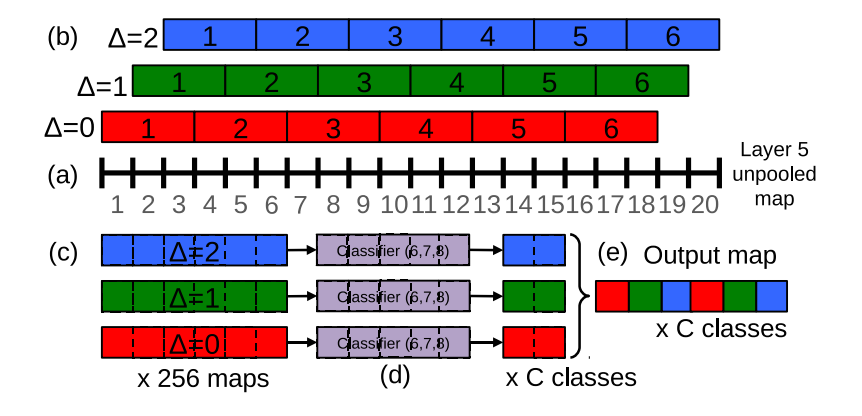
- 이 그림은 1차원 스케일에 대한 출력값이다. pooling을 거치고 나면 데이터양이 1/3로 줄어들뿐만 아니라, resolution역시 1/3로 줄어들기 때문에 위치의 정확도도 그만큼 떨어진다. 하지만 위 그림처럼, offset을 $\Delta$를 1데이터 단위로 하게 되면, 1 데이터 간격으로 각각 pooling을 진행하고, 그 결과를 Classifier에 적용하게 되면, pooling 이전의 해상도를 유지할 수 있어, pooling이후 1번만 classifier연산을 하는 것에 비해 훨씬 조밀한 검사(dense evaluation)을 할수 있데 되는 것이다.

    - (a) unpooled layer 5 에 20개의 데이터가 있다고 가정한다.
    - (b) 이것에 대해 3x1 non-overlapped pooling을 한다고 하자. RGB에따라 오프셋값을 {0,1,2}를 준다.
    - (c) 각 RGB마다 서로 다른 6개의 데이터가 생긴다. ()
    - (d) Classifier(layer 6,7)이 sliding window fashion적용된다.각$\Delta$마다 C map에 의해 2개의 데이터가 생성된다. (3번의 연산)
    - (e) 다시 재조합하여 6개의 데이터로 만든다.(해상도 유지)

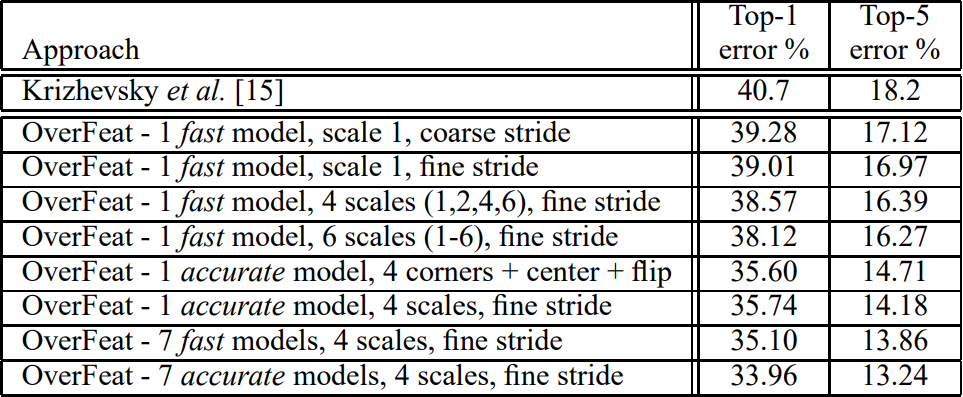
- 위 그림은 accurate model의 구성을 보여주는 그림이다.
- Accurate model에서 stride부분을 주목해서 살펴보면, Layer 1에서 Conv와 pooling을 거치면 영상의 크기가 1/6로 줄어든다.
- Layer 2를 거치면 다시 1/2로 줄어들고, Layer6의 pooling을 거치면, 다시1/3이 줄어들어 전체적으로 Layer6를 거치고 나면, Layer7의 classifier로 입력의 1 픽셀은 실제 입력 영상의 36픽셀에 해당하게 된다.
- OverFeat의 입력 영상의 크기가 221 x 221인 것을 감안하면, Layer7의 1픽셀의 해상도가 36픽셀에 해당하기 때문에 너무 간격이 듬성듬성하게 된다.
- 그래서 OverFeat 설계자가 고려한 부분은 classifier에 연결되는 Layer6의 pooling 부분에 주목을 하였다. Pooling의 stride가 3x3이기 때문에 pooling 단 앞단의 해상도는 36픽셀이 아니라 12 픽셀 수준이 되며, pooling 이전 단 기준으로 1픽셀씩 offset을 갖고 pooling을 수행하면 classifier로 들어가는 데이터의 양은 결과적으로 3x3, 즉 9배만큼 많아지지만, 해상력은 그만큼 좋아지게 된다.

- <span class="mark">Lecun은 FC-layer를 1x1 convolution으로 이해를 하고 있다. lecun의 말처럼, FC-layer를 1x1 convolution으로 본다면, conv/pooling layer를 처리할때와 마찬가지로 sliding window개념을 적용할 수 있다.</span>

- 그간 ConvNet 설계자들이 어려워 했던 부분은 convolution부분은 영상의 크기에 상관없이 적용이 가능하지만, Fully-connected layer 부분은 fixed size를 갖고 있기 때문에 sliding window 개념이 아니라, ConvNet 앞단에서 fixed size를 고려한 crop을 수행하고 항상 FC layer 앞단에는 동일한 크기의 feature map이 확보되도록 하였다.

- 그렇지만, FC layer가 개념적으로 보면 1x1 convolution으로 볼 수 있기 때문에 이제는 FC-layer 앞단의 feature-map 크기에 연연해 할 이유가 없어지는 것이다.

- 이 개념을 2차원 구조를 갖는 영상에 적용하게 되면, 간단하게 예시를 하면 아래 그림과 같다.
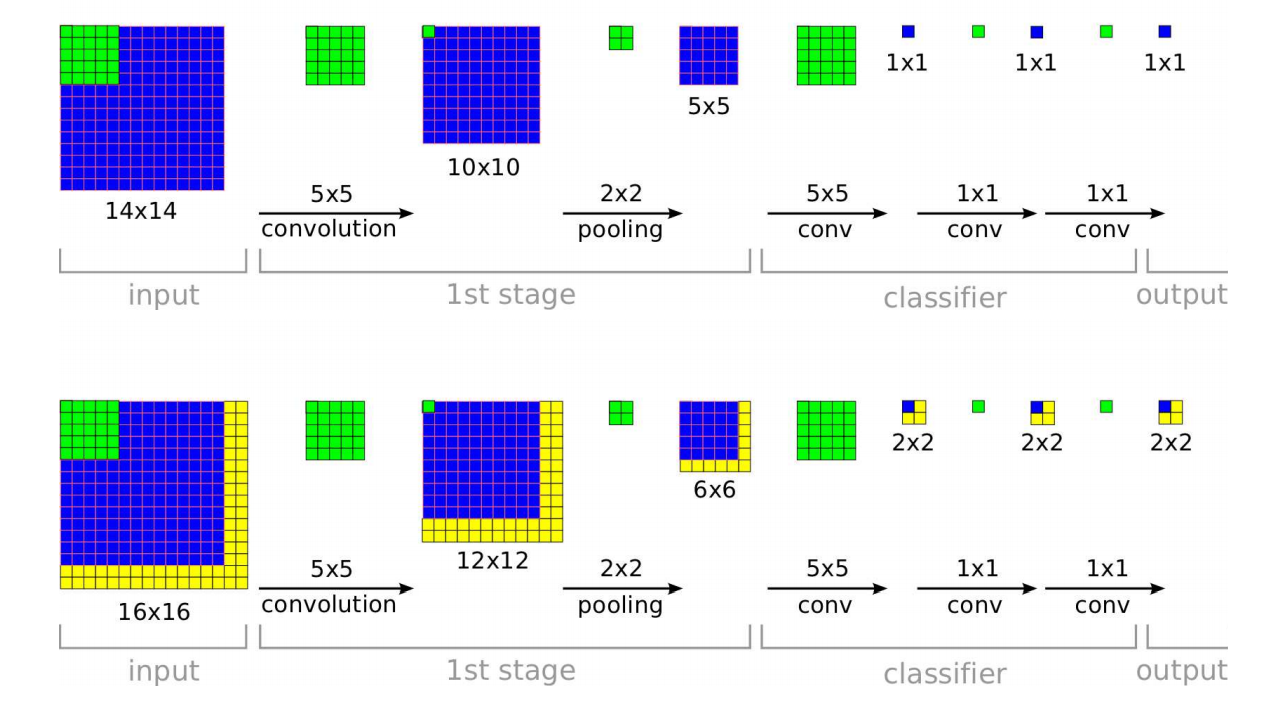

- 상단은 학습 과정을 보여준다. 입력 이미지의 크기가 14 x 14인 경우에 conv/pooling을 거쳐 최종적으로 5x5 크기를 얻은 후 classifier를 거쳐 학습을 한다.
- 하단은 입력영상보다 크기가 큰 16x16영상을 test입력으로 사용하게 된다면, FC-layer 앞단에서는 6x6 크기의 feature-map이 얻어지고, 이것은 sliding window개념으로 해석하면, 5x5 window 4개가 있는 것으로 볼수 있고, 최종적으로 2x2 차원의 최종 출력을 얻게 된다.
- 이 개념이 확보되었으므로 이제 큰 이미지의 특정 위치를 무작위로 선택하는 것이 아니라 일정한 resolution 단위로 선택을 할 수 있게 된다.
- 또한 영상의 scale이 바뀌더라도, 바뀐 scale에 맞춰 sliding window를 움직이면서 결과를 얻으면 된다.

- 아래 그림은 4개의 scale에 대해 dense evaluation을 보여주는 그림이다. scale에 따라 특정 대상이 나타났다가 사라질수 있으며, voting 개념을 활용하여 대상을 classification 및 localization시킬 수 있다.
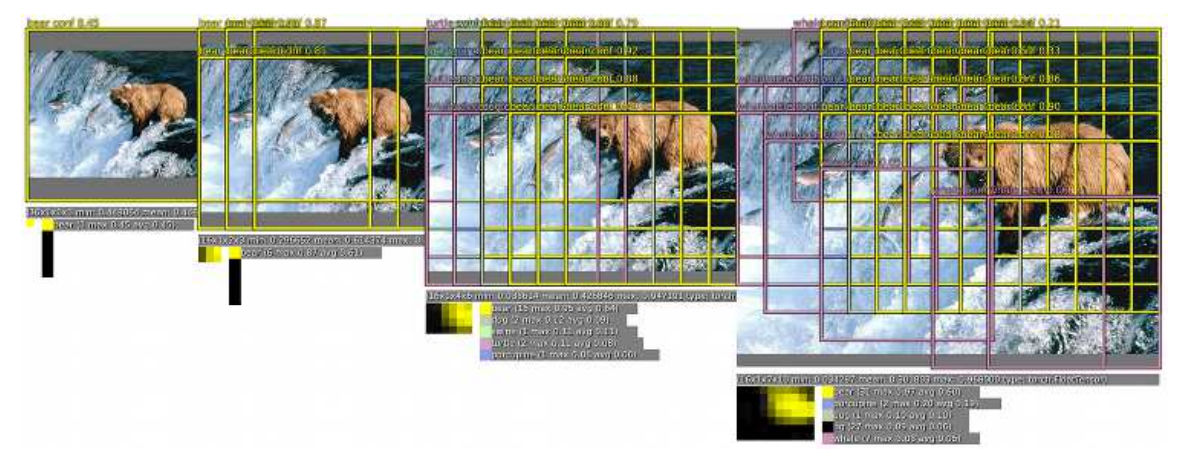

- Localization은 대상의 위치나 형태에 맞춰 bounding box까지 학습을 해줘야 한다. Classification과 동일한 학습이미지에 대해 bounding box까지 있는 ground-truth 데이터를 이용해 localization을 학습시킨다.
- Classification과 많은 부분을 공유하며, 최종단에 있는 classifier 부분을 bounding box regression network로 치환해주고, bounding box를 각각의 위치 및 scale에 맞게 학습을 시킨다.  
  
- 아래 그림은 동일 영상에 대해 voting에 의해 특정 대상이 검출되고 대상에 맞춰 bounding box를 찾아주는 것을 보여주는 그림이다.
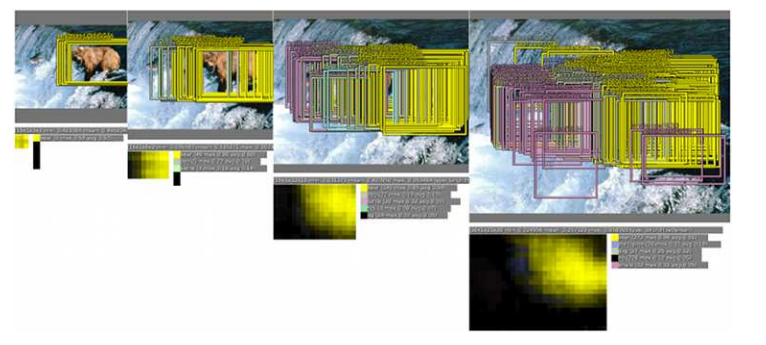

- crop의 경우 처럼 원 학습 영상으로부터 영상을 잘라낸 후 그것들을 각각 ConvNet에 적용시키는 방식이 아니라, 큰 영상에 대해 곧바로 ConvNet을 적용하고 일정한 픽셀 간격(grid)으로 sliding window를 적용하듯이 결과를 끌어낼 수 있어, 연산량 관점에서는 매우 효율적이지만, grid크기 문제로 인해서 학습 결과가 약간 떨어질 수 있다. 그러므로 crop과 dense evaluation을 상보적으로(complemetary) 섞어 사용하면 더 성능이 좋아진다.

## OverFeat 결과

- 아래는 OverFeat의 실험 결과이다.
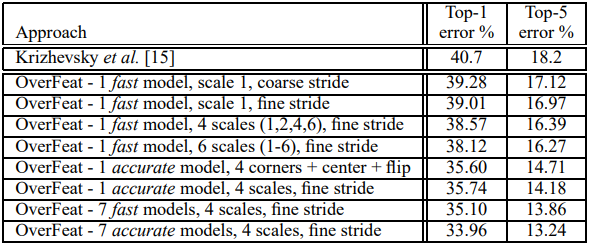
- 이 결과를 보면, model voting과 4 scale, dense evaluation을 사용한 경우 top-5 에러율이 13.24로 상당히 좋은 결과를 낸다는 것을 알 수 있다.
- Dense evaluation을 사용하면, 겹치는 부분에 대한 연산을 공유할 수 있어 전반적으로 연산량이 줄어든다.
- Grid 크기에 대한 우려가 있을 수 있지만, grid 크기를 연산량과 고려하여 적절한 수준으로 유지하면 결과가 좋다.